# Series de Tiempo
## Trabajo Final - Parte Bitcoin ARIMA

**Presentado por:**
- Miguel Ángel Quintero
- Natalia Castilla
- Juan Pablo Saenz

In [377]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

import scipy as sp
import scipy.stats
import scipy.special

import datetime as dt

In [378]:
df = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
df["Timestamp"] = pd.to_datetime(df["Timestamp"],unit='s')
df

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1,2011-12-31 07:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-12-31 07:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-12-31 07:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-12-31 07:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
4857372,2021-03-30 23:56:00,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
4857373,2021-03-30 23:57:00,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
4857374,2021-03-30 23:58:00,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
4857375,2021-03-30 23:59:00,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202


## 1. Preprocesamiento

El objetivo es hacer el análisis del modelo para datos con una frecuencia mensual. Para esto será necesario:
- Borrar los Nans presentes en la base de datos
- Hacer un resampling de la base de datos para trabajar con datos mensuales. En este caso se tomará el valor medio del precio del bitcoin en dicho mes tanto para el precio de cierre y apertura.

In [379]:
df_bitcoin = df.copy()
df_bitcoin = df_bitcoin.dropna()
df_bitcoin = df_bitcoin.drop(['Volume_(BTC)','Volume_(Currency)','Weighted_Price'],axis=1)
df_bitcoin = df_bitcoin.set_index('Timestamp')
df_bitcoin = df_bitcoin.resample('M').mean()
print(df_bitcoin.index)

DatetimeIndex(['2011-12-31', '2012-01-31', '2012-02-29', '2012-03-31',
               '2012-04-30', '2012-05-31', '2012-06-30', '2012-07-31',
               '2012-08-31', '2012-09-30',
               ...
               '2020-06-30', '2020-07-31', '2020-08-31', '2020-09-30',
               '2020-10-31', '2020-11-30', '2020-12-31', '2021-01-31',
               '2021-02-28', '2021-03-31'],
              dtype='datetime64[ns]', name='Timestamp', length=112, freq='M')


Ahora se hace el drop de algunas columnas que no son de interés y de está forma se tendrá la base con la se trabajará para el modelo.

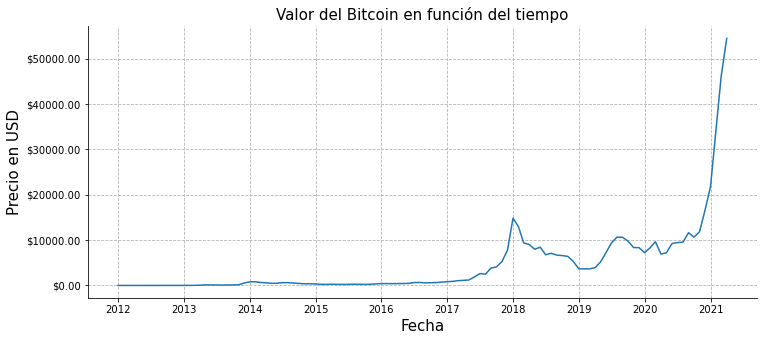

In [421]:
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(111)
ax1.plot(df_bitcoin.index,df_bitcoin['Close'])
ax1.set_title("Valor del Bitcoin en función del tiempo", size=15)
ax1.set_xlabel("Fecha", size=15)
ax1.yaxis.set_major_formatter('${x:1.2f}')
ax1.set_ylabel("Precio en USD", size=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
plt.grid(ls='--',alpha=7)
plt.savefig('Bitcoin_vs_tiempo.png')

En este caso, se puede observar claramente que la serie no es estacionaria, ya que se observa heterocedasticidad a lo largo de esta.

## 1.1. Analísis de tendencia, ciclos y estacionalidades
A priori la serie no parece tener tendencia, ciclos y estacionales. No obstante, se observa una clara varianca marginal en cada punto. Para este analisis, se usará la función *seasonal_decompose* de statsmodels.

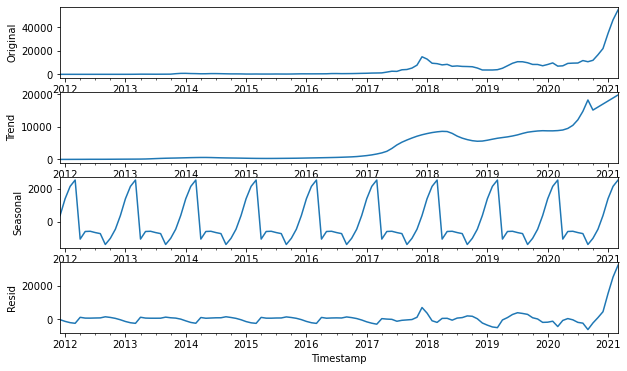

In [436]:
result = seasonal_decompose(df_bitcoin.Close, model='additive',extrapolate_trend=6)

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(411)
result.observed.plot(ax=ax1)
ax1.set_ylabel('Original')
ax2 = fig.add_subplot(412)
result.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
ax3 = fig.add_subplot(413)
result.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
ax4 = fig.add_subplot(414)
result.resid.plot(ax=ax4)
ax4.set_ylabel('Resid')

plt.savefig('seasonal_decompose.png')
plt.show()

Se observa claramente que no existe realmente una tendencia estimada por la función. Adicionalmente, se observa un efecto de estacionalidad. Para determinar finalmente si es o no estacionaria, se aplicará el estadístico de prueba de Dickey-Fuller, el cual arroja que la serie no es estacionaria con un 99.88% de confianza.

In [382]:
print('Prueba de Dickey-Fuller: ',adfuller(df_bitcoin.Close)[1])

Prueba de Dickey-Fuller:  0.9988330355043566


## 1.2. Heterocedasticidad
Como se observó en la serie, posiblemente presenta una varianza marginal no constante. Por tal motivo, se aplicará box-cox para observar los resultados.

In [383]:
sp.stats.boxcox(df_bitcoin.Close,alpha=0.05)

(array([ 1.63662167,  2.05771   ,  1.82101287,  1.76325758,  1.7659678 ,
         1.77831495,  1.99827089,  2.33296152,  2.7570574 ,  2.81030086,
         2.82762983,  2.79546353,  2.99822226,  3.24614317,  3.99275883,
         5.23564451,  6.47984291,  6.34226186,  6.17045711,  5.79654226,
         6.13920932,  6.44523587,  6.80910735,  9.18630291, 10.02617864,
        10.09242713,  9.62239351,  9.40130455,  8.89252473,  9.01629529,
         9.47789076,  9.49181072,  9.18632745,  8.81075023,  8.41410632,
         8.43975474,  8.30081095,  7.64955972,  7.57234559,  7.83140162,
         7.57125486,  7.59465806,  7.60449957,  7.90723323,  7.70515686,
         7.57193579,  7.83000551,  8.34627257,  8.71428967,  8.65740034,
         8.61587281,  8.68113951,  8.75745809,  8.89600694,  9.57459536,
         9.6315767 ,  9.35364837,  9.44156464,  9.56898596,  9.82332242,
        10.10964186, 10.31342308, 10.65487885, 10.79392808, 10.94759153,
        11.97413779, 12.76826098, 12.6454515 , 13.7

Al realizar box-cox, se observa que el valor de $\lambda$ es diferente de 0, y se encuentra dentro de intervalo de confianza para un α = 0.05. Adicionalmente, este intevarlo no incluye el valor de 1, por lo cual se tiene heterocedasticidad en la serie. Entonces, se procederá a utilizar el parametro estimado por scipy.

In [384]:
logdf=sp.stats.boxcox(df_bitcoin.Close)
df_bitcoin['Close_BoxCox'] = logdf[0]
print('Prueba de Dickey-Fuller: ', adfuller(df_bitcoin['Close_BoxCox'])[1])

Prueba de Dickey-Fuller:  0.9263361648557694


No obstante, al realizar la prueba de Dickey-Fuller, la serie sigue sin ser estacionaria.

## 1.3. Diferenciación

In [386]:
dif_df=df_bitcoin['Close_BoxCox'].diff(periods=1).dropna()
print('Prueba de Dickey-Fuller: ', adfuller(dif_df)[1])

Prueba de Dickey-Fuller:  3.879978849571618e-09


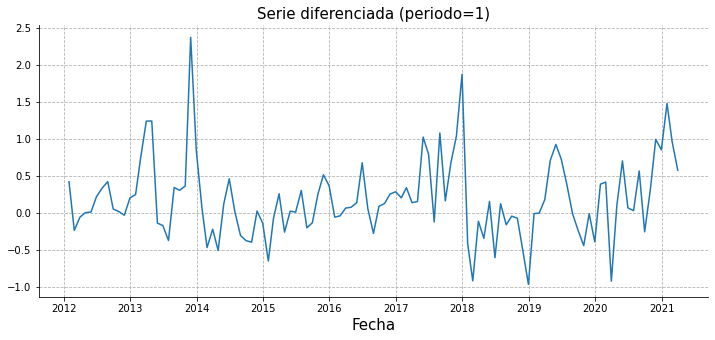

In [437]:
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(111)
ax1.plot(dif_df.index,dif_df)
ax1.set_title("Serie diferenciada (periodo=1)", size=15)
ax1.set_xlabel("Fecha", size=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
plt.grid(ls='--',alpha=7)
plt.savefig('mes_bitcoin_diferenciada.png')

Los resultados muestran que la serie ya es estacionaria, no obstance, se realizará un analisis adicional antes de implementar el modelo ARIMA para observar las posibles autocorrelaciones

## 1.4. Autocorrelación
AL realizar los gráficos de autocorrelaciones observamos que en la serie original presenta significancia para los primeros 3-4 lags, lo cual nos da idea del parametro de Autoregresión del modelo. En el caso de las autocorrelaciones de la serie diferenciada, solo presenta significancia para el primer lag, lo cual puede no ser significante a la hora de implementar el modelo.

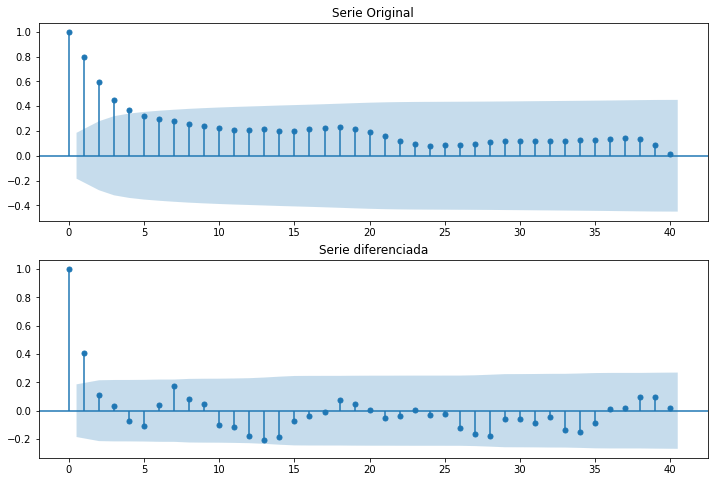

In [438]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
plot_acf(df_bitcoin.Close,lags=40,title='Serie Original',ax=ax1)

ax2 = fig.add_subplot(212)
plot_acf(dif_df.dropna(),lags=40,title='Serie diferenciada',ax=ax2)


plt.savefig('Autocorrelacion_mensual.png')
plt.show()

# 2. Modelo ARIMA

El modelo ARIMA corresponde a:
- AR: Modelo Autoregresivo
- I: Integrado
- MA: Media Móvil

Representado por ARIMA(p,d,q) dondep corresponde al número de retardos (lags) a incluir, d es el número de veces que el modelo es diferenciado y finalmente q es el orden de la media movil.

## 2.1. Parametros

Para la selección de los parametros, se usará el criterio de información Akaike (AIC) y se realizará una iteración sobre el rango de valores de los parametros que se consideran relevantes de acuerdo al análisis anterior.

In [395]:
df_bitcoin

,Open,High,Low,Close,Close_BoxCox
Timestamp,,,,,
2011-12-31,4.465000,4.482500,4.465000,4.482500,1.636622
2012-01-31,6.345389,6.348982,6.341218,6.346148,2.057710
2012-02-29,5.230208,5.231646,5.227036,5.228510,1.821013
2012-03-31,4.985481,4.986695,4.982580,4.983828,1.763258
2012-04-30,4.995171,4.996447,4.993763,4.995079,1.765968
...,...,...,...,...,...
2020-11-30,16535.778528,16545.663704,16525.571002,16536.023486,17.816209
2020-12-31,21811.751812,21826.119052,21796.889787,21812.155606,18.671102
2021-01-31,34554.125793,34594.169353,34512.497779,34554.252479,20.152623


In [396]:
p = range(0, 4)
q = range(0, 4)
d=1
param = list(itertools.product(p, q))

AIC_values = []
for i in param:
    model = ARIMA(df_bitcoin.Close_BoxCox, order=(i[0], d, i[1]))
    results = model.fit()
    AIC_values.append([i,results.aic])

C:\Users\maquimar\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\maquimar\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\maquimar\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\maquimar\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [397]:
AIC = pd.DataFrame(AIC_values,columns=['Parametros','AIC'])
AIC.sort_values(by='AIC',ascending=True).head(5)

,Parametros,AIC
4,"(1, 0)",163.891650
9,"(2, 1)",164.182099
5,"(1, 1)",165.814879
8,"(2, 0)",165.834894
10,"(2, 2)",166.107486


In [399]:
final = ARIMA(df_bitcoin.Close_BoxCox, order=(1, 1, 0)).fit()
final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Close_BoxCox   No. Observations:                  112
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -79.946
Date:                Thu, 29 Jul 2021   AIC                            163.892
Time:                        23:09:53   BIC                            169.311
Sample:                    12-31-2011   HQIC                           166.090
                         - 03-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4684      0.065      7.213      0.000       0.341       0.596
sigma2         0.2467      0.021     11.604      0.000       0.205       0.288
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                42.29
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                             0.61
Prob(H) (two-sided):                  0.71   Kurtosis:                         5.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Para el modelo ARIMA(1,1,0) o ARI(1,1), se observa que todas las variables son significativas además de demostrar el valor AIC más bajo. No obstante, la prueba de normalidad de Jarque-Bera muestra que el supuesto de normalidad de los residuales no se cumple.

Para esto, observemos la gráfica de los residuales (gráfica de arriba a la derecha)

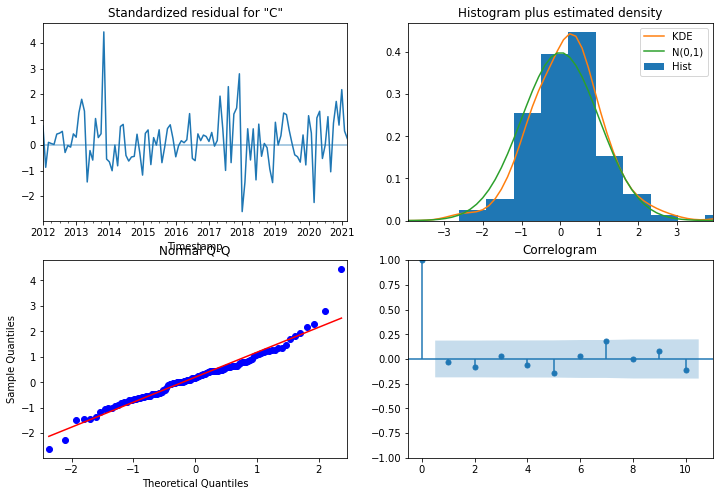

In [400]:
final.plot_diagnostics(figsize=(12,8))
plt.show()

No obstante, como nuestro objetivo es la predicción, aunque es deseable que se cumplan los supuestos, se intentará hacer predicción bajo estos resultados.

## 2.2. Predicción
Se intentará realizar la predicción para los siguientes 12 meses.

In [409]:
df_predict

,Predicción
2011-12-31,0.000000
2012-01-31,1.636622
2012-02-29,2.254936
2012-03-31,1.710151
2012-04-30,1.736207
...,...
2021-12-31,22.208746
2022-01-31,22.209040
2022-02-28,22.209178
2022-03-31,22.209243


In [411]:
df_predict = pd.DataFrame()
df_predict['Predicción'] = final.predict(end=124)
df_final = pd.concat([df_bitcoin,df_predict],axis=1)
df_final['Predicción_invBox'] = sp.special.inv_boxcox(df_final['Predicción'],logdf[1])

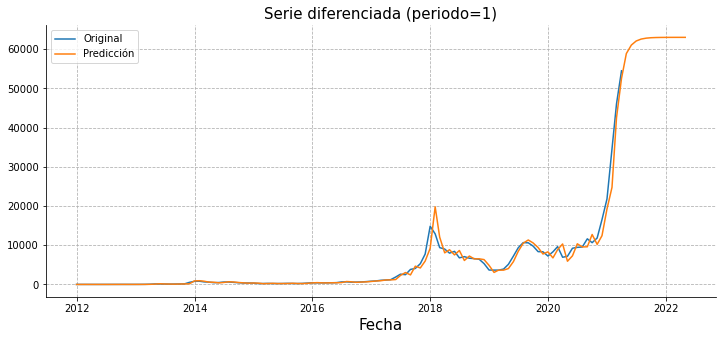

In [439]:
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(111)
ax1.plot(df_final.index,df_final['Close'],label='Original')
ax1.plot(df_final.index,df_final['Predicción_invBox'],label='Predicción')
ax1.set_title("Serie diferenciada (periodo=1)", size=15)
ax1.set_xlabel("Fecha", size=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.legend()
plt.grid(ls='--',alpha=7)
plt.savefig('ARIMA_prediccion.png')

## 2.3. Error cuadratico medico
Para evaluar el desempeño del modelo y compararlo con los otros modelos realizados, se procede a calcular el error cuadratico medio.

In [445]:
print('El RMSE es: ', np.sqrt(np.mean(np.power(df_final["Predicción_invBox"] -df_final["Close"],2))))

El RMSE es:  1580.5064235011118
